In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Import data & data selection 

In [7]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

## Mencari tahu range data

In [8]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

In [9]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country',
'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## Time series indexing

In [10]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Karena datetime yang kita miliki adalah berdasarkan order date, sehingga perlu ada
penyesuaian interval waktu yang konstant agar modeling lebih mudah dilakukan.
Maka proses selanjutnya adalah membuat rata-rata penjualan bulanan.

In [11]:
y = furniture['Sales'].resample('MS').mean()

y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualisasi data time series furniture

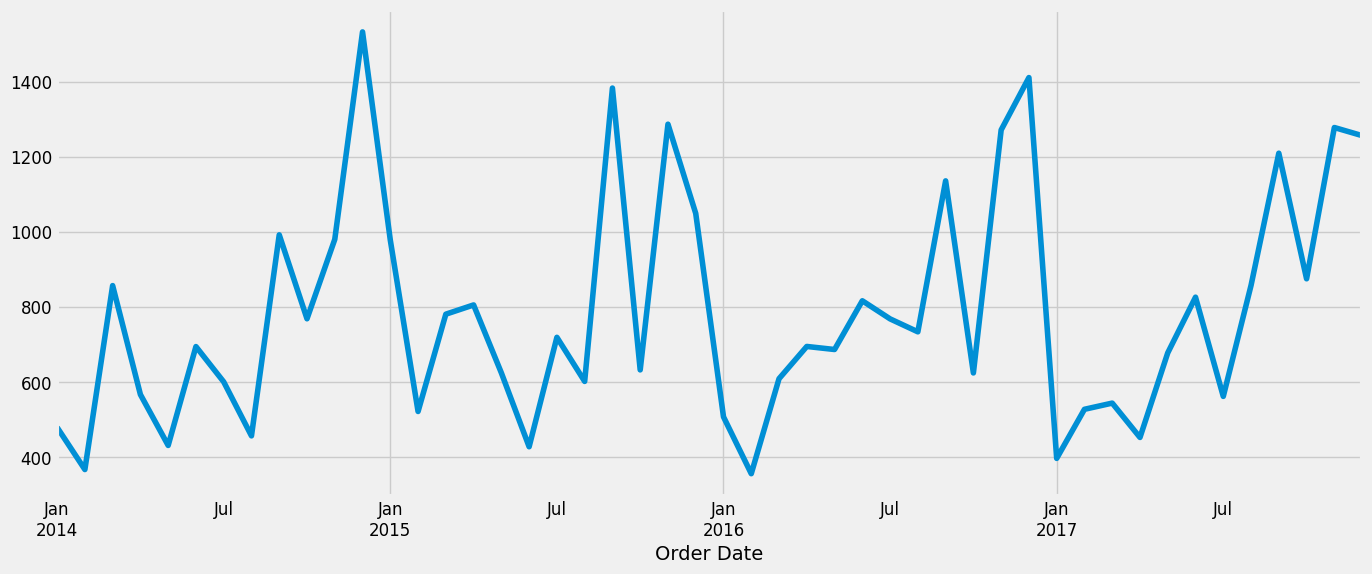

In [12]:
y.plot(figsize=(15, 6))
plt.show()

Beberapa pola menarik akan terlihat ketika kita memvisualisasikan data tersebut.
Time series data akan memiliki pola musiman. Pada tahap ini kita akan melakukan
dekomposisi terhadap data time series.

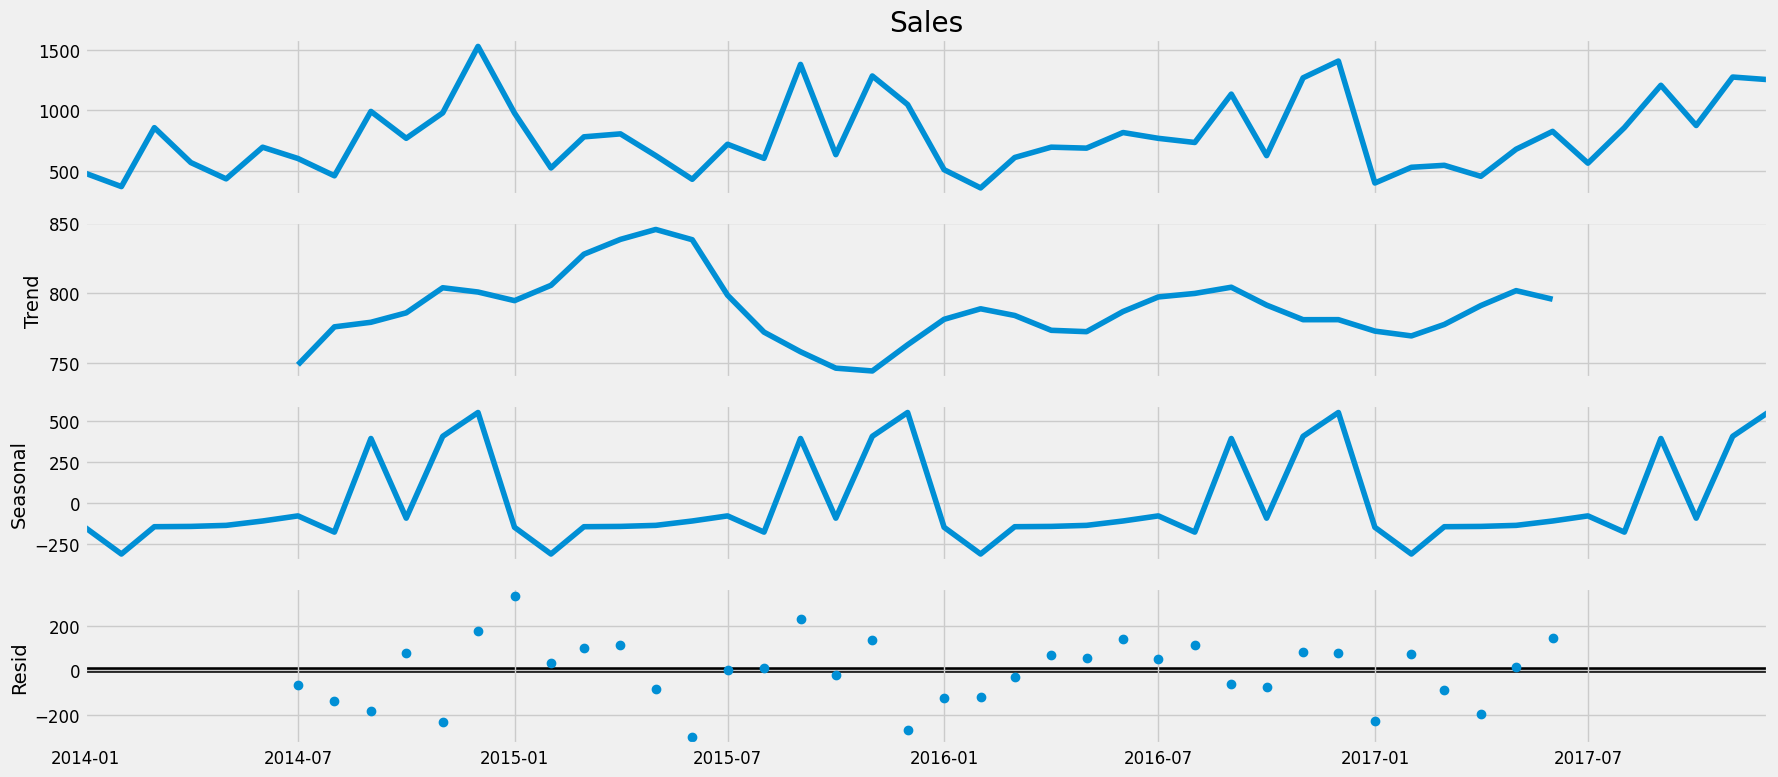

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# ARIMA

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Grid search

Pada tahap ini kita akan melakukan parameter selection dengan model grid search.
Tujuannya adalah mengetahui parameter terbaik dan paling optimal untuk solusi
saat ini.

In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99048D+00    |proj g|=  1.66962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.398D-07   7.990D+00
  F =   7.9904349200061615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1523.5085449297978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96130D+00    |proj g|=  7.02705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   3.189D-07   4.955D+00
  F =   4.9553855530413573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13783D+00    |proj g|=  5.06000D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   5.054D-05   5.138D+00
  F =   5.1378275348107687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66131D+01    |proj g|=  5.42384D-03
  ys=-1.369E+02  -gs= 7.239E-01 BFGS update SKIPPED


 This problem is unconstrained.


  ys=-7.242E+01  -gs= 7.207E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     83      3     2     0   7.719D+04   1.366D+01
  F =   13.658019648806201     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1317.1698862853953
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27088D+00    |proj g|=  6.03846D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.15658D+00    |proj g|=  3.15535D-02

At iterate   10    f=  3.15479D+00    |proj g|=  1.07910D-03

At iterate   15    f=  3.12010D+00    |proj g|=  1.47086D-01

At iterate   20    f=  3.10676D+00    |proj g|=  3.81418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     31      1     0     0   2.982D-06   3.107D+00
  F =   3.1067586253159725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.462E+04  -gs= 2.286E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     27      2     1     0   8.845D+04   2.823D+01
  F =   28.225482192966126     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2715.646290524748
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81850D+00    |proj g|=  1.63640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03608D+00    |proj g|=  1.53380D-01

At iterate    5    f=  3.01401D+00    |proj g|=  3.58462D-03


 This problem is unconstrained.



At iterate   10    f=  3.00248D+00    |proj g|=  9.13790D-02

At iterate   15    f=  2.97527D+00    |proj g|=  7.09124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   3.840D-07   2.975D+00
  F =   2.9752722809096865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673299
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77847D+00    |proj g|=  3.74770D-02


 This problem is unconstrained.



At iterate    5    f=  5.77414D+00    |proj g|=  8.20004D-04

At iterate   10    f=  5.77045D+00    |proj g|=  3.10556D-02

At iterate   15    f=  5.42367D+00    |proj g|=  2.22856D+00

At iterate   20    f=  5.23799D+00    |proj g|=  5.22752D-01

At iterate   25    f=  5.18503D+00    |proj g|=  1.92784D-01

At iterate   30    f=  5.16011D+00    |proj g|=  5.51824D-02

At iterate   35    f=  5.14999D+00    |proj g|=  6.44619D-03

At iterate   40    f=  5.14672D+00    |proj g|=  1.71218D-02

At iterate   45    f=  5.14340D+00    |proj g|=  1.38744D-02

At iterate   50    f=  5.14182D+00    |proj g|=  5.35613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-7.579E+05  -gs= 4.520E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     29      2     1     0   1.700D+05   2.602D+01
  F =   26.020577174943821     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2505.9754087946067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30136D+00    |proj g|=  8.81709D-03

At iterate    5    f=  3.30121D+00    |proj g|=  1.24498D-03



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  3.29918D+00    |proj g|=  3.27117D-02

At iterate   15    f=  3.27151D+00    |proj g|=  2.08396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.068D-06   3.271D+00
  F =   3.2707134134863209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03608D+00    |proj g|=  1.53380D-01


 This problem is unconstrained.



At iterate    5    f=  3.01570D+00    |proj g|=  2.21140D-02

At iterate   10    f=  3.01390D+00    |proj g|=  1.40285D-03

At iterate   15    f=  3.01088D+00    |proj g|=  2.00589D-02

At iterate   20    f=  2.96843D+00    |proj g|=  3.42226D-02

At iterate   25    f=  2.95716D+00    |proj g|=  2.42029D-03

At iterate   30    f=  2.95702D+00    |proj g|=  2.13623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     46      1     0     0   3.209D-06   2.957D+00
  F =   2.9570058087886437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576437

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     80      4     2     0   3.249D+04   1.415D+01
  F =   14.149310747444622     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1362.3338317546836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06688D+00    |proj g|=  9.86171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.334E+01  -gs= 6.880E-01 BFGS update SKIPPED
  ys=-1.550E+01  -gs= 6.786E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.329E+01  -gs= 6.880E-01 BFGS update SKIPPED

At iterate    5    f=  1.46538D+01    |proj g|=  8.19469D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6    107      3     3     0   8.195D+02   1.465D+01
  F =   14.653817026447591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1412.7664345389687
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28929D+00    |proj g|=  4.82161D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.822D-06   3.289D+00
  F =   3.2892854876137618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.759E+04  -gs= 4.143E+03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     44      3     2     0   6.593D+05   2.010D+01
  F =   20.095953998514510     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1935.211583857393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76190D+00    |proj g|=  1.01285D-01

At iterate    5    f=  4.74718D+00    |proj g|=  5.28400D-04

At iterate   10    f=  4.74705D+00    |proj g|=  1.11248D-02


 This problem is unconstrained.



At iterate   15    f=  4.73828D+00    |proj g|=  3.49609D-03

At iterate   20    f=  4.73823D+00    |proj g|=  9.05942D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     22      1     0     0   9.059D-08   4.738D+00
  F =   4.7382349463361750     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482728
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97823D+00    |proj g|=  1.50080D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  2.92864D+00    |proj g|=  5.96714D-03

At iterate   15    f=  2.92143D+00    |proj g|=  7.46461D-02

At iterate   20    f=  2.87919D+00    |proj g|=  1.99187D-02

At iterate   25    f=  2.85662D+00    |proj g|=  4.00632D-02

At iterate   30    f=  2.84985D+00    |proj g|=  3.99135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     43      1     0     0   8.989D-06   2.850D+00
  F =   2.8497981597930742     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233401351
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     69      2     0     0   7.985D-01   2.660D+01
  F =   26.595504603209175     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2561.1684419080807
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23022D+00    |proj g|=  3.65785D-02

At iterate    5    f=  3.22401D+00    |proj g|=  7.08917D-02

At iterate   10    f=  3.21896D+00    |proj g|=  1.01148D-03

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.93137D+00    |proj g|=  4.51405D-02

At iterate   10    f=  2.92843D+00    |proj g|=  1.02500D-03

At iterate   15    f=  2.92822D+00    |proj g|=  2.90988D-02

At iterate   20    f=  2.89347D+00    |proj g|=  2.64524D-01

At iterate   25    f=  2.85822D+00    |proj g|=  2.18987D-01

At iterate   30    f=  2.84956D+00    |proj g|=  8.30576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     45      1     0     0   6.298D-06   2.850D+00
  F =   2.8495589806888080     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-3.258E+02  -gs= 7.279E-01 BFGS update SKIPPED

At iterate    5    f=  1.82255D+01    |proj g|=  4.44274D+03
  ys=-3.730E+01  -gs= 7.154E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     80      2     2     0   4.443D+03   1.823D+01
  F =   18.225544182452317     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1755.6522415154225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95274D+00    |proj g|=  4.17506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.



At iterate   10    f=  3.14134D+00    |proj g|=  3.70899D-02

At iterate   15    f=  3.10841D+00    |proj g|=  4.52844D-02

At iterate   20    f=  3.10633D+00    |proj g|=  1.63010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   1.291D-06   3.106D+00
  F =   3.1063309116260061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609657
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.09833D+00    |proj g|=  1.23092D-02

At iterate   10    f=  5.09817D+00    |proj g|=  1.03693D-02

At iterate   15    f=  5.07999D+00    |proj g|=  1.97990D-01

At iterate   20    f=  4.94876D+00    |proj g|=  1.37195D-01

At iterate   25    f=  4.94715D+00    |proj g|=  1.24014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   4.998D-07   4.947D+00
  F =   4.9471451749324951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679351955
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1258.8183236593795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14966D+00    |proj g|=  6.73283D-02

At iterate    5    f=  3.14546D+00    |proj g|=  3.59066D-03

At iterate   10    f=  3.13253D+00    |proj g|=  7.92846D-02

At iterate   15    f=  3.10903D+00    |proj g|=  5.29964D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   1.330D-06   3.109D+00
  F =   3.1090257032131370     

CONVERGENCE: 

 This problem is unconstrained.



At iterate    5    f=  3.14669D+00    |proj g|=  2.12240D-02

At iterate   10    f=  3.14460D+00    |proj g|=  2.49106D-03

At iterate   15    f=  3.14450D+00    |proj g|=  4.78054D-03

At iterate   20    f=  3.13450D+00    |proj g|=  6.55616D-02

At iterate   25    f=  3.10013D+00    |proj g|=  7.09175D-02

At iterate   30    f=  3.08947D+00    |proj g|=  1.52019D-02

At iterate   35    f=  3.08942D+00    |proj g|=  3.72324D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     42      1     0     0   3.723D-06   3.089D+00
  F =   3.0894194709831519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79387D+01    |proj g|=  7.86502D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  2.79236D+01    |proj g|=  2.21511D-01
  ys=-7.264E-11  -gs= 1.775E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.62625D+01    |proj g|=  8.52042D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11    149      4     1     0   8.520D+04   2.626D+01
  F =   26.262525632515576     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2529.2024607214953
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82203D+00    |proj g|=  9.77386D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.81853D+00    |proj g|=  1.78050D-02

At iterate   10    f=  4.81634D+00    |proj g|=  1.74889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     27      1     0     0   5.353D-05   4.816D+00
  F =   4.8163387456398139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195814221
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03742D+00    |proj g|=  1.63757D-01

At iterate    

 This problem is unconstrained.



At iterate   20    f=  2.97263D+00    |proj g|=  3.96818D-03

At iterate   25    f=  2.97231D+00    |proj g|=  2.58393D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   2.584D-06   2.972D+00
  F =   2.9723147853811942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659466
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  5.11566D+00    |proj g|=  2.79617D-01

At iterate    5    f=  5.04734D+00    |proj g|=  1.37385D-02

At iterate   10    f=  5.04246D+00    |proj g|=  2.25429D-03

At iterate   15    f=  5.04233D+00    |proj g|=  1.07594D-02

At iterate   20    f=  5.02608D+00    |proj g|=  1.61370D-01

At iterate   25    f=  4.94416D+00    |proj g|=  2.94009D-02

At iterate   30    f=  4.94350D+00    |proj g|=  2.63489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   1.480D-05   4.944D+00
  F =   4.9435034623715604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     75      2     0     0   8.564D+04   2.530D+01
  F =   25.302750350544102     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2439.064033652234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15364D+00    |proj g|=  6.09532D-02

At iterate    5    f=  3.14852D+00    |proj g|=  6.15365D-03

At iterate   10    f=  3.14679D+00    |proj g|=  2.38071D-02

At iterate   1

 This problem is unconstrained.



At iterate   25    f=  2.99312D+00    |proj g|=  7.16761D-02

At iterate   30    f=  2.97362D+00    |proj g|=  9.14707D-02

At iterate   35    f=  2.95837D+00    |proj g|=  1.12411D-01

At iterate   40    f=  2.95575D+00    |proj g|=  4.45084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     56      1     0     0   9.092D-06   2.956D+00
  F =   2.9557429042981220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.75131881261973
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70970D+01    |proj g|=  2.00943D-03
  ys=-1.635E+02  -gs= 7.053E-01 BFGS update SKIPPED
  ys=-2.407E+01  -gs= 6.886E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     80      2     2     0   5.085D+03   1.671D+01
  F =   16.712313684481334     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1610.3821137102082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95000D+00    |proj g|=  4.81428D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.95798D+00    |proj g|=  2.40641D-02

At iterate   10    f=  4.90324D+00    |proj g|=  1.99571D-01

At iterate   15    f=  4.88896D+00    |proj g|=  2.69660D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   2.697D-06   4.889D+00
  F =   4.8889621445673308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1387.56288308395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10197D+00    |proj g|=  1.68835D-02

At iterate    5    f=  3.10136D+00    |proj g|=  1.04559D-02


 This problem is unconstrained.



At iterate   10    f=  3.08543D+00    |proj g|=  1.26873D-01

At iterate   15    f=  3.06903D+00    |proj g|=  1.52921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.073D-06   3.069D+00
  F =   3.0690321889014704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454116


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12416D+00    |proj g|=  1.59332D-01

At iterate    5    f=  3.09966D+00    |proj g|=  1.44150D-02

At iterate   10    f=  3.09925D+00    |proj g|=  2.70335D-03

At iterate   15    f=  3.09397D+00    |proj g|=  5.42312D-02

At iterate   20    f=  3.06825D+00    |proj g|=  1.66878D-02

At iterate   25    f=  3.06621D+00    |proj g|=  1.00833D-02

At iterate   30    f=  3.06590D+00    |proj g|=  1.38402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   20    f=  6.69897D+00    |proj g|=  4.59316D-02

At iterate   25    f=  6.69825D+00    |proj g|=  5.88969D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     33      1     0     0   5.890D-06   6.698D+00
  F =   6.6982479373280244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019834904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62901D+01    |proj g|=  6.21298D-03


 This problem is unconstrained.


  ys=-3.208E+03  -gs= 2.213E+03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     65      2     1     0   1.668D+06   1.028D+01
  F =   10.278765146866748     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:994.7614540992078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77247D+00    |proj g|=  5.57251D-02

At iterate    5    f=  4.74738D+00    |proj g|=  7.45904D-02

At iterate   10    f=  4.74215D+00    |proj g|=  5.05521D-04



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f=  4.74189D+00    |proj g|=  1.89004D-02

At iterate   20    f=  4.73466D+00    |proj g|=  2.88447D-02

At iterate   25    f=  4.73413D+00    |proj g|=  7.19638D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     33      1     0     0   7.196D-06   4.734D+00
  F =   4.7341277995934687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.476268760973
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


  ys=-4.857E-03  -gs= 6.535E-03 BFGS update SKIPPED

At iterate    5    f=  2.92491D+00    |proj g|=  2.97664D-02

At iterate   10    f=  2.92293D+00    |proj g|=  1.02711D-03

At iterate   15    f=  2.92057D+00    |proj g|=  3.20001D-02

At iterate   20    f=  2.87973D+00    |proj g|=  3.06134D-02

At iterate   25    f=  2.84939D+00    |proj g|=  4.57853D-02

At iterate   30    f=  2.84778D+00    |proj g|=  1.98146D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     1     0   2.277D-06   2.848D+00
  F =   2.8477843822285114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.92820D+00    |proj g|=  4.33012D-03

At iterate   10    f=  4.92756D+00    |proj g|=  2.13740D-02

At iterate   15    f=  4.86782D+00    |proj g|=  3.01010D-01

At iterate   20    f=  4.80756D+00    |proj g|=  3.28931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   5.416D-07   4.808D+00
  F =   4.8075524527717741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546609034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     28      2     1     0   1.242D+06   1.445D+01
  F =   14.448034078693381     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1397.0112715545645
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02

At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-0

 This problem is unconstrained.



At iterate   10    f=  2.92298D+00    |proj g|=  1.23344D-02

At iterate   15    f=  2.92270D+00    |proj g|=  1.02674D-03

At iterate   20    f=  2.92162D+00    |proj g|=  6.40702D-02

At iterate   25    f=  2.86053D+00    |proj g|=  1.47426D-01

At iterate   30    f=  2.84756D+00    |proj g|=  5.89292D-03

At iterate   35    f=  2.84756D+00    |proj g|=  2.47752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     48      1     0     0   3.164D-05   2.848D+00
  F =   2.8475635567501265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661014480

## Implementasi model

Pada tahap sebelumnya, ditemukan parameter terbaik ada pada model ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.36610143633357
Karena memiliki nilai AIC terendah, sehingga parameter ARIMA tersebut akan kita
gunakan sebagai model forecasting

## Model fitting

In [21]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02


 This problem is unconstrained.



At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-04  -gs= 2.696E-04 BFGS update SKIPPED

At iterate   15    f=  3.07434D+00    |proj g|=  9.55769D-04

At iterate   20    f=  3.07399D+00    |proj g|=  2.28491D-02

At iterate   25    f=  3.04252D+00    |proj g|=  2.03789D-01

At iterate   30    f=  3.01863D+00    |proj g|=  1.40615D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     58      1     1     0   9.416D-05   3.019D+00
  F =   3.0186202495191208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

## Validasi hasil

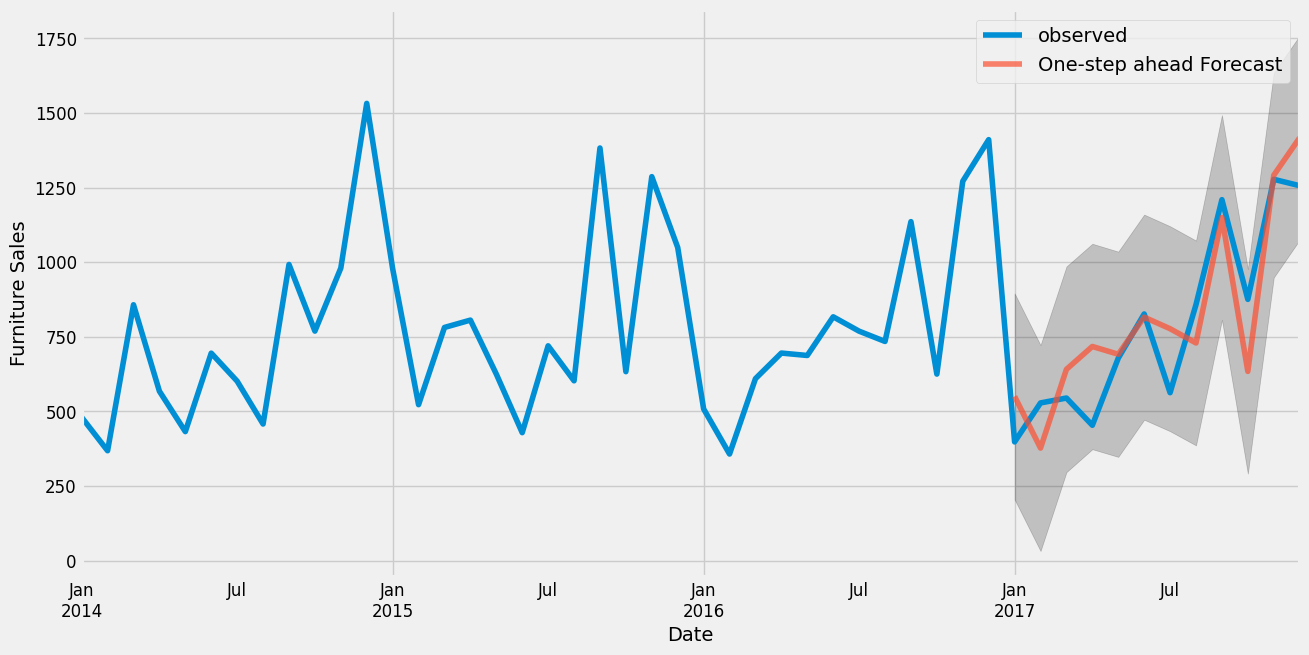

The Mean Squared Error of our forecasts is 22993.57
The Root Mean Squared Error of our forecasts is 151.64


In [24]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

## Melakukan forecast untuk beberapa step kedepan

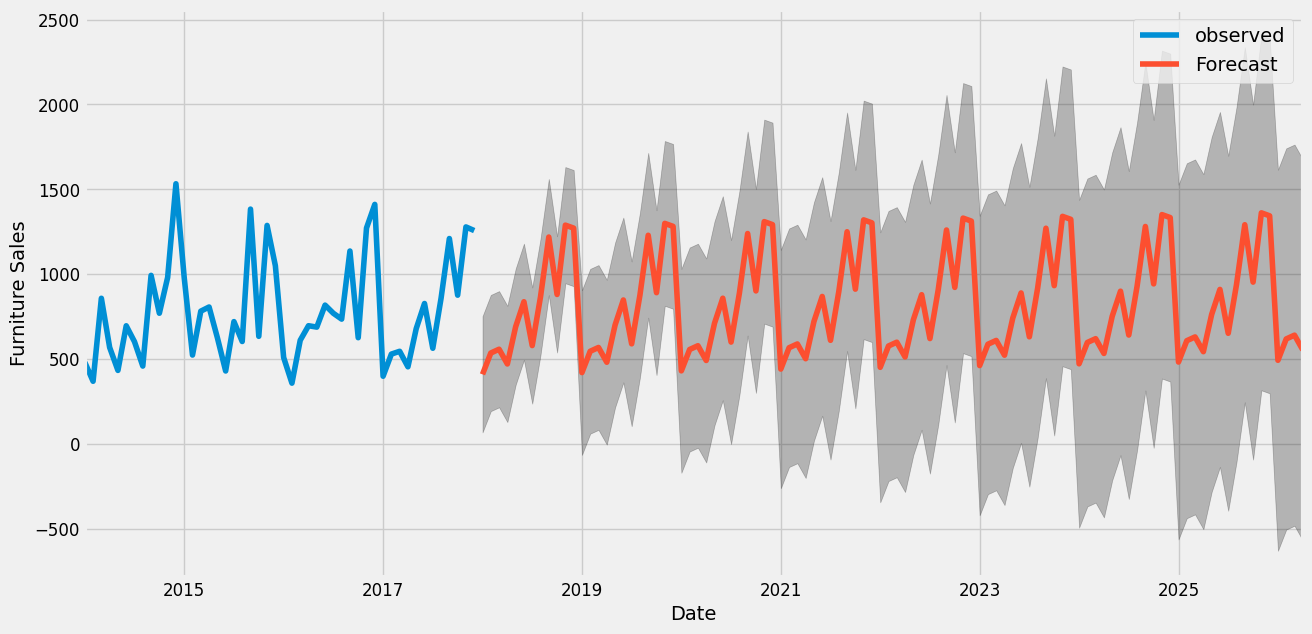

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()